# PyTorch实例3：微博谣言检测
作者：杨邦

邮箱：yangbang@pku.edu.cn

日期：2022-09-28

## 3.1 导入程序包

In [153]:
!pip install jieba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [154]:
import json, os
from tqdm import tqdm

#PyTorch用的包
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# 自然语言处理相关的包
import re #正则表达式的包
import jieba #结巴分词包
from collections import Counter #搜集器，可以让统计词频更简单

#绘图、计算用的程序包
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## 3.2 数据预处理

### 3.2.1 数据下载

In [155]:
!git clone https://github.com/thunlp/Chinese_Rumor_Dataset.git

fatal: destination path 'Chinese_Rumor_Dataset' already exists and is not an empty directory.


In [156]:
!ls ./Chinese_Rumor_Dataset
!ls ./Chinese_Rumor_Dataset/CED_Dataset/

CED_Dataset  README.md	rumors_v170613.json
non-rumor-repost  original-microblog  README.md  rumor-repost


### 3.2.2 获取微博文本及其配对标签

In [157]:
# 数据来源文件夹 -- 内含多个json文件
non_rumor = './Chinese_Rumor_Dataset/CED_Dataset/non-rumor-repost'
rumor = './Chinese_Rumor_Dataset/CED_Dataset/rumor-repost'
original = './Chinese_Rumor_Dataset/CED_Dataset/original-microblog'

non_rumor_data = []
rumor_data = []

# 遍历文件夹，读取文本数据
print('开始读取数据')
for file in tqdm(os.listdir(original)):
    try:
        data = json.load(open(os.path.join(original, file), 'rb'))['text']
    except:
        continue

    is_rumor = (file in os.listdir(rumor))
    if is_rumor:
        rumor_data.append(data)
    else:
        non_rumor_data.append(data)

print('结束, 有{}条谣言, 有{}条非谣言!'.format(len(rumor_data), len(non_rumor_data)))
print(non_rumor_data[-2:])
print('-'*20)
print(rumor_data[-2:])


# 把数据储存到指定地方 -- 统一到2个txt文件
pth = './rumor_detection_data'
if not os.path.exists(pth):
    os.makedirs(pth)

good_file = os.path.join(pth, 'non_rumor.txt')
bad_file = os.path.join(pth, 'rumor.txt')

with open(good_file, 'w', encoding='utf-8') as f:
    f.write('\n'.join(non_rumor_data))
with open(bad_file, 'w', encoding='utf-8') as f:
    f.write('\n'.join(rumor_data))

开始读取数据


100%|██████████| 3389/3389 [00:06<00:00, 503.61it/s]

结束, 有1538条谣言, 有1849条非谣言!
['《20131031查娱饭后 张杰部分》 （分享自 @土豆娱乐） http://t.cn/zR9kUdU ', '首都北京城牛了！一个小时，十三号线西直门着火了，二号线积水潭有人卧轨了，五号线陶然亭成下水道了，大望路出门必须开船了，分钟寺小狗都游泳过马路了，地下车库成游泳馆了，首都机场飞机以为自己到马尔代夫了！一场雨而已嘛，至于这么紧张吗：地铁封，公交无，的士停，私车趴！PS：这是帝都？首堵？']
--------------------
['愤怒！世间怎有如此忘恩负义之人！这位老人九十多岁了，家人平时给他吃剩下的饭菜，还让他干活，他给家里人洗衣服，不小心把衣服洗坏了，他儿子就打他骂他，还让他跪一天.如果你们有谁觉得他儿子连畜生都不如的请转发,告诫我们一定要做孝顺的子女,有爸妈的请转发,没有良心就算了.可怜天下父母心呐！', '【这是一个外国人无法理解的国家】北京，一名外国大姐挡在一辆驶入非机动车道的京HL2021车前，微笑着劝说司机回到机动车道去，司机先是鸣喇叭，再谩骂，后推搡，要老外让开，老外坚持着不让。司机最后夺过自行车丢在了路边，在非机动车道上扬长驶去。围观的国人在边上笑看不知所措的外国大姐....（转）']


### 3.2.3 文本预处理（过滤标点，分词）

In [158]:
# 将文本中的标点符号过滤掉
def filter_punc(sentence):
    sentence = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？?、~@#￥%……&*（）：:；“”】》《-【\][]", "",sentence.strip())
    return sentence

# 扫描所有的文本，分词、建立词典，分出是谣言还是非谣言，is_filter可以过滤是否筛选掉标点符号
def Prepare_data(good_file, bad_file, is_filter = True, threshold=3):
    all_words = [] #存储所有的单词
    pos_sentences = [] #存储非谣言
    neg_sentences = [] #存储谣言
    with open(good_file, 'r', encoding='utf-8') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                #过滤标点符号
                line = filter_punc(line)
                if not idx: # 只打印第一个例子看看
                    print('分词前：', line)
            #分词
            words = jieba.lcut(line)
            if not idx: # 只打印第一个例子看看
                print('分词后：', words)
            if len(words) > 0:
                all_words += words
                pos_sentences.append(words)
    print('{0} 包含 {1} 行, {2} 个词.'.format(good_file, idx+1, len(all_words)))

    count = len(all_words)
    with open(bad_file, 'r', encoding='utf-8') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                line = filter_punc(line.strip())
            words = jieba.lcut(line)
            if len(words) > 0:
                all_words += words
                neg_sentences.append(words)
    print('{0} 包含 {1} 行, {2} 个词.'.format(bad_file, idx+1, len(all_words)-count))

    #建立词典，只保留频次大于threshold的单词
    vocab = {'<unk>': 0}
    cnt = Counter(all_words)
    for word, freq in cnt.items():
        if freq > threshold:
            vocab[word] = len(vocab)
        
    print('过滤掉词频 <= {}的单词后，字典大小：{}'.format(threshold, len(vocab)))
    return pos_sentences, neg_sentences, vocab


pos_sentences, neg_sentences, vocab = Prepare_data(good_file, bad_file, True, threshold=3)

分词前： 最值得爱一生的五大星座排名第一名巨蟹座不畏艰辛患难与共第二名金牛座不离不弃第三名处女座不逃避困难第四名魔羯座一起吃苦第五名天蝎座真情守护被巨蟹座爱上是需要几世才能修来的好福气啊
分词后： ['最', '值得', '爱', '一生', '的', '五大', '星座', '排名', '第一名', '巨蟹座', '不畏', '艰辛', '患难与共', '第二名', '金牛座', '不离', '不弃', '第三名', '处女座', '不', '逃避', '困难', '第四名', '魔羯座', '一起', '吃苦', '第五名', '天蝎座', '真情', '守护', '被', '巨蟹座', '爱上', '是', '需要', '几世', '才能', '修来', '的', '好福气', '啊']
./rumor_detection_data/non_rumor.txt 包含 1849 行, 92943 个词.
./rumor_detection_data/rumor.txt 包含 1538 行, 78645 个词.
过滤掉词频 <= 3的单词后，字典大小：6690


### 3.2.4 数据集划分

In [159]:
# 获得句子的向量化表示
def sentence2vec(word_ids, vocab_size):
    vector = np.zeros(vocab_size)
    for word_id in word_ids:
        vector[word_id] += 1
    return 1.0 * vector / len(word_ids)

# bow = [] #词袋
# labels = [] #标签
# sentences = [] #原始句子，调试用
# sentences_id = [] #原始句子对应的index列表

# # 处理非谣言
# for sentence in pos_sentences:
#     new_sentence = []
#     for word in sentence:
#         new_sentence.append(vocab[word] if word in vocab else vocab['<unk>'])
    
#     bow.append(sentence2vec(new_sentence, len(vocab)))
#     labels.append(0) #正标签为0
#     sentences.append(sentence)
#     sentences_id.append(new_sentence)

# # 处理谣言
# for sentence in neg_sentences:
#     new_sentence = []
#     for word in sentence:
#         new_sentence.append(vocab[word] if word in vocab else vocab['<unk>'])

#     bow.append(sentence2vec(new_sentence, len(vocab)))
#     labels.append(1) #负标签为1
#     sentences.append(sentence)
#     sentences_id.append(new_sentence)

# # 打乱所有的数据顺序，形成数据集
# # indices为所有数据下标的一个全排列
# indices = np.random.permutation(len(bow))

# #对整个数据集进行划分，分为：训练集、验证集和测试集，这里是2:1:1
# test_size = len(bow) // 4

# data = {
#     'bow': bow,# 词袋数据
#     'labels': labels,# 标签
#     'sentences_id': sentences_id,# 句子对应的下标列表
#     'sentences': sentences,# 句子
#     'vocab': vocab # 词典,
# }
# split = {
#     'train': indices[test_size:],
#     'vali': indices[test_size:2*test_size],
#     'test': indices[:test_size]
# }

########k折划分############
def data_and_split(i, k):
  bow = [] #词袋
  labels = [] #标签
  sentences = [] #原始句子，调试用
  sentences_id = [] #原始句子对应的index列表

  # 处理非谣言
  for sentence in pos_sentences:
    new_sentence = []
    for word in sentence:
        new_sentence.append(vocab[word] if word in vocab else vocab['<unk>'])
    
    bow.append(sentence2vec(new_sentence, len(vocab)))
    labels.append(0) #正标签为0
    sentences.append(sentence)
    sentences_id.append(new_sentence)

  # 处理谣言
  for sentence in neg_sentences:
    new_sentence = []
    for word in sentence:
        new_sentence.append(vocab[word] if word in vocab else vocab['<unk>'])

    bow.append(sentence2vec(new_sentence, len(vocab)))
    labels.append(1) #负标签为1
    sentences.append(sentence)
    sentences_id.append(new_sentence)

  # 打乱所有的数据顺序，形成数据集
  # indices为所有数据下标的一个全排列
  indices = np.random.permutation(len(bow))

  #对整个数据集进行划分，分为：训练集、验证集和测试集，这里是2:1:1
  test_size = len(bow) // 4
  
  t_rain = None
  data = {
    'bow': bow,# 词袋数据
    'labels': labels,# 标签
    'sentences_id': sentences_id,# 句子对应的下标列表
    'sentences': sentences,# 句子
    'vocab': vocab # 词典,
  }
  split = {
    'train': indices[test_size:],
    'vali': indices[test_size:2*test_size],
    'test': indices[:test_size]
  }
  fold_size = test_size * 3 // k
  for j in range(k):
    X = indices[test_size + j * fold_size : test_size + (j + 1) * fold_size]
    if j == i:
      split['vali'] = X
    elif t_rain is None:
      t_rain = X
    else:
      t_rain = np.append(t_rain, X)
  split['train'] = t_rain

  return data, split

In [ ]:
# 测试一下划分情况
data, split = data_and_split(0,5)
for key, indices in split.items():
    count = [0, 0]
    for idx in indices:
        count[labels[idx]] += 1
    print(key, '非谣言有{}条，谣言有{}条'.format(count[0], count[1]))

train 非谣言有1108条，谣言有920条
vali 非谣言有260条，谣言有247条
test 非谣言有478条，谣言有368条


## 3.3 训练/测试函数定义

In [ ]:
class AverageMeter(object):
    """
    用于储存与计算平均值
    """ 
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1, multiply=True):
        self.val = val
        if multiply:
            self.sum += val * n
        else:
            self.sum += val
        self.count += n
        self.avg = self.sum / self.count

def training(model, loader, crit, optim, device):
    # 模型调成训练模式
    model.train()
    # 把模型移到指定设备
    model.to(device)
    # 用于记录损失和正确率
    meter_loss, meter_acc = AverageMeter(), AverageMeter()
    
    for data in loader:
        # 清空梯度
        optim.zero_grad()
        # 获取数据并将其移至指定设备中, cpu / gpu
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        # 将输入送入网络，获得输出
        outputs = model(inputs)
        # 计算损失
        loss = crit(outputs, labels)
        # 反向传播，计算梯度
        loss.backward()
        # 更新网络参数
        optim.step()
        
        # 记录损失
        num_sample = inputs.size(0)
        meter_loss.update(loss.item(), num_sample)
        # 记录预测正确率
        preds = outputs.max(dim=1)[1] # 网络预测的类别结果
        correct = (preds == labels).sum() # 计算预测的正确个数
        meter_acc.update(correct.item(), num_sample, multiply=False)
    
    # 返回训练集的平均损失和平均正确率
    return meter_loss.avg, meter_acc.avg

@torch.no_grad()
def evaluate(model, loader, crit, device):
    # 模型调成评估模式
    model.eval()
    # 把模型移到指定设备
    model.to(device)
    # 用于记录损失和正确率
    meter_loss, meter_acc = AverageMeter(), AverageMeter()
    for data in loader:
        # 获取数据并将其移至指定设备中, cpu / gpu
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.view(-1)
        # 将输入送入网络，获得输出
        outputs = model(inputs)
        
        # 计算并记录损失
        loss = crit(outputs, labels)
        num_sample = inputs.size(0)
        meter_loss.update(loss.item(), num_sample)
        # 记录预测正确率
        preds = outputs.max(dim=1)[1] # 网络预测的类别结果
        correct = (preds == labels).sum() # 计算预测的正确个数
        meter_acc.update(correct.item(), num_sample, multiply=False)

    return meter_loss.avg, meter_acc.avg

## 3.4 词袋模型

### 3.4.1 数据加载器定义

In [ ]:
class BaseDataset(Dataset):
    def __init__(self, data, split):
      super().__init__()
      self.make_dataset(data, split)

    def make_dataset(self, data, split):
      # Data是包含了整个数据集的数据
      # 而我们只需要训练集/验证集/测试集的数据
      # 我们按照划分基准split里面的下标来确定加载哪部分的数据
      self.dataset = []
      for idx in split:
        item = [torch.FloatTensor(data['bow'][idx]), 
            torch.LongTensor([data['labels'][idx]])]
        self.dataset.append(item)

    def __getitem__(self, ix):
      # ix大于等于0，小于len(self.dataset)
      return self.dataset[ix]
    
    def __len__(self):
      # 一共有多少数据
      return len(self.dataset)


def get_loader(i, k, batch_size=64, class_func=BaseDataset):
    # split.keys() 包括 'train', 'vali', 'test'
    # 所以此函数是为了拿到训练集，验证集和测试集的数据加载器
    # 返回第i折交叉验证时所需要的训练和验证数据，分开放，X_train为训练数据，X_valid为验证数据
    data, split = data_and_split(i, k)
    loader = []
    for mode in split.keys():
      # split[mode]指定了要取data的哪些数据
      dataset = class_func(data, split[mode])
      # Dataloader可帮助我们一次性取batch_size个样本出来
      loader.append(DataLoader(dataset, batch_size = batch_size, shuffle = True if mode=='train' else False))
    return loader

In [ ]:
# 测试一下
_, _, fake_loader = get_loader(0, 5)
x, y = iter(fake_loader).__next__()
print('词袋输入的形状：', x.shape)
print('标签的形状：', y.shape)

词袋输入的形状： torch.Size([64, 6690])
标签的形状： torch.Size([64, 1])


### 3.4.2 模型定义

In [185]:
# 一个简单的前馈神经网络，三层，第一层线性层，加一个非线性ReLU，第二层线性层
# 输入维度为词典的大小：每一段评论的词袋模型

# class Linear_Model(torch.nn.Module):
#     def __init__(self, vocab_size, hidden_size, num_class=2, dropout=0):
#         super(Linear_Model,self).__init__()
        
#         self.net = nn.Sequential(
#                     nn.Linear(vocab_size, hidden_size),
#                     nn.ReLU(),
#                     nn.Dropout(dropout),
#                     nn.Linear(hidden_size, num_class),
#                 )
        
#     def forward(self,x):
#         print('x0: ', x.size())
#         x = self.net(x)
#         print('x1: ', x.size())
#         x = F.log_softmax(x, dim=1)
#         print('x2: ', x.size())
#         return x


class Linear_Model(torch.nn.Module):
    def __init__(self, vocab_size, hidden_size, num_class=2, dropout=0):
        super(Linear_Model,self).__init__()
        self.pre = nn.Sequential(
                    nn.Linear(vocab_size, hidden_size),
                    nn.ReLU(),
                )
        self.net1 = nn.Sequential(
                    nn.Linear(vocab_size, hidden_size),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                    nn.Linear(hidden_size, hidden_size),
                    nn.ReLU(),
                )
        self.net2 = nn.Sequential(
                    nn.Linear(hidden_size, hidden_size),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                    nn.Linear(hidden_size, num_class),
                )
        
    def forward(self,x):
      input = self.pre(x)
      x = self.net1(x)
      x = self.net2(x + input)
      x = F.log_softmax(x, dim=1)
      return x


### 3.4.3 运行

In [186]:
# 参数
num_epochs = 10
learning_rate = 0.005
batch_size = 32
vocab_size = len(vocab)
hidden_size = 10
dropout = 0.5
k = 5

# 运行的设备
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# 模型实例化
model = Linear_Model(vocab_size, hidden_size, dropout=dropout)
# 打印模型
print(model)
# 损失函数 -- 交叉熵
crit = torch.nn.NLLLoss()
# 优化方法 -- Adam
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

records = []
for epoch in range(num_epochs):
  print('*' * 25, '第', epoch + 1, '轮', '*' * 25)
  for i in range(k):
    print('*' * 10, '第', i + 1, '折', '*' * 10)
    # 数据加载器
    train_loader, vali_loader, test_loader = get_loader(i, k, batch_size=batch_size, class_func=BaseDataset)
    # 训练
    train_loss, train_acc = training(model, train_loader, crit, optimizer, device)
    # 验证
    vali_loss, vali_acc = evaluate(model, vali_loader, crit, device)
    # 打印消息
    print('训练集损失：{:.5f}, 训练集准确率：{:.5f}, 验证集损失：{:.5f}, 验证集准确率: {:.5f}'.format(
        train_loss, train_acc, vali_loss, vali_acc))
    # 储存信息以便可视化
    records.append([train_loss, train_acc, vali_loss, vali_acc])
# 测试
_, test_acc = evaluate(model, test_loader, crit, device)
print('测试集正确率：', test_acc)

Linear_Model(
  (pre): Sequential(
    (0): Linear(in_features=6690, out_features=10, bias=True)
    (1): ReLU()
  )
  (net1): Sequential(
    (0): Linear(in_features=6690, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
  (net2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=10, out_features=2, bias=True)
  )
)
************************* 第 1 轮 *************************
********** 第 1 折 **********
训练集损失：0.70141, 训练集准确率：0.50049, 验证集损失：0.67409, 验证集准确率: 0.81460
********** 第 2 折 **********
训练集损失：0.61357, 训练集准确率：0.67751, 验证集损失：0.49842, 验证集准确率: 0.78501
********** 第 3 折 **********
训练集损失：0.44562, 训练集准确率：0.82791, 验证集损失：0.32756, 验证集准确率: 0.90138
********** 第 4 折 **********
训练集损失：0.32343, 训练集准确率：0.88905, 验证集损失：0.23178, 验证集准确率: 0.91124
********** 第 5 折 **********
训练集损失：0.27482, 训

### 3.4.4 训练过程损失&准确率的变化

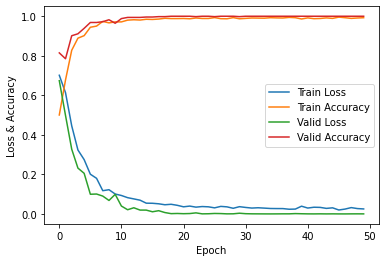

In [187]:
# 绘制误差曲线
plt.plot([i[0] for i in records], label = 'Train Loss')
plt.plot([i[1] for i in records], label = 'Train Accuracy')
plt.plot([i[2] for i in records], label = 'Valid Loss')
plt.plot([i[3] for i in records], label = 'Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss & Accuracy')
plt.legend()
plt.show()

## 3.5 Transformer

### 3.5.1 数据加载器定义

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, split):
      super().__init__()
      self.vocab = data['vocab']
      self.pad_index = len(self.vocab.keys()) if '<pad>' not in self.vocab.keys() else self.vocab['<pad>']
      self.max_len = data.get('max_len', 30)
      self.make_dataset(data, split)

    def make_dataset(self, data, split):
      # Data是包含了整个数据集的数据
      # 而我们只需要训练集/验证集/测试集的数据
      # 我们按照划分基准split里面的下标来确定加载哪部分的数据
      self.dataset = []
      for idx in split:
        this_sentence_id = data['sentences_id'][idx]
        item = [
            torch.LongTensor(self.pad_data(this_sentence_id)), 
            torch.LongTensor([data['labels'][idx]])
            ]
        self.dataset.append(item)

    def pad_data(self, seq):
      # 让序列长度最长只有max_len，不足就补pad，超过就截断
      if len(seq) < self.max_len:
        seq += [self.pad_index] * (self.max_len - len(seq))

      else:
        seq = seq[:self.max_len]
      return seq
    
    def get_pad_index(self):
      return self.pad_index
            
    def __getitem__(self, ix):
      # ix大于等于0，小于len(self.dataset)
      return self.dataset[ix]
    
    def __len__(self):
      # 一共有多少数据
      return len(self.dataset)

### 3.5.2 Transformer基础组件实现

In [ ]:
import math
class ScaledDotProductAttention(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout):
        super().__init__()
        assert hidden_size % num_heads == 0
        self.num_heads = num_heads
        self.attention_head_size = hidden_size // num_heads
        self.all_head_size = hidden_size

        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def transpose_for_scores(self, x: torch.Tensor) -> torch.Tensor:
        new_x_shape = x.size()[:-1] + (self.num_heads, self.attention_head_size)
        x = x.view(*new_x_shape) # [bsz, seq_len, n_head, head_size]
        return x.permute(0, 2, 1, 3) # [bsz, n_head, seq_len, head_size]

    def forward(self, q, k, v, attention_mask=None):
        query = self.transpose_for_scores(self.query(q)) # [bsz, n_head, lq, head_size]
        key = self.transpose_for_scores(self.key(k))     # [bsz, n_head, lk, head_size]
        value = self.transpose_for_scores(self.value(v)) # [bsz, n_head, lv, head_size]
        
        attention_scores = torch.matmul(query, key.transpose(-1, -2)) # [bsz, n_head, lq, lk]
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        if attention_mask is not None:
            if attention_mask.dim() == 2:
                attention_mask = attention_mask[:, None, None, :] # [bsz, 1, 1, lk]
            if attention_mask.dim() == 3:
                attention_mask = attention_mask[:, None, :, :] # [bsz, 1, lq, lk]
            attention_scores = attention_scores.masked_fill(attention_mask, -1e9)

        attention_probs = nn.Softmax(dim=-1)(attention_scores)
        attention_probs = self.dropout(attention_probs) # [bsz, n_head, lq, lk]

        context = torch.matmul(attention_probs, value) # [bsz, n_head, lq, head_size]
        context = context.permute(0, 2, 1, 3).contiguous() # [bsz, lq, n_head, head_size]

        new_context_shape = context.size()[:-2] + (self.all_head_size,)
        context = context.view(*new_context_shape) # [bsz, lq, dim_hidden]

        return context, attention_probs


class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, num_heads, attn_dropout, dropout):
        super().__init__()
        self.SDPA = ScaledDotProductAttention(hidden_size, num_heads, attn_dropout)
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.LayerNorm = nn.LayerNorm(hidden_size)
        
    def forward(self, hidden_states, attention_mask=None):
        q, k, v = hidden_states, hidden_states, hidden_states
        context, attention_probs = self.SDPA(q, k, v, attention_mask)
        context = self.dense(context)
        context = self.dropout(context)

        hidden_states = self.LayerNorm(hidden_states + context)
        return hidden_states, attention_probs


class FeedForwardNetwork(nn.Module):
    def __init__(self, hidden_size, intermediate_size, dropout=.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, intermediate_size),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(intermediate_size, hidden_size),
            nn.Dropout(dropout)
        )
        self.LN = nn.LayerNorm(hidden_size)
    
    def forward(self, x):
        return self.LN(x + self.net(x))


class TransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_size, num_heads, intermediate_size, attn_dropout=.0, dropout=.0):
        super().__init__()
        self.mha = MultiHeadAttention(hidden_size, num_heads, attn_dropout, dropout)
        self.ffn = FeedForwardNetwork(hidden_size, intermediate_size, dropout)
    
    def forward(self, hidden_states, attention_mask):
        hidden_states, _ = self.mha(hidden_states, attention_mask)
        hidden_states = self.ffn(hidden_states)
        return hidden_states


class TransformerEncoder(nn.Module):
    def __init__(self, hidden_size, num_layers, num_heads, intermediate_size, attn_dropout=.0, dropout=.0):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(hidden_size, num_heads, intermediate_size, attn_dropout, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, attn_mask):
        for layer in self.layers:
            x = layer(x, attn_mask)
        return x

### 3.5.3 模型定义

In [ ]:
class TFModel(nn.Module):
    def __init__(self, 
            vocab_size, 
            hidden_size, 
            max_len, 
            pad_index, 
            num_class=2, 
            num_heads=4, 
            num_layers=1, 
            dropout=0.0, 
            attn_dropout=0.0
    ):
        super().__init__()
        self.word_embs = nn.Embedding(vocab_size + 1, hidden_size, padding_idx=pad_index)
        self.position_embs = nn.Embedding(max_len+1, hidden_size)

        self.net = TransformerEncoder(
            hidden_size, 
            num_layers, 
            num_heads, 
            4 * hidden_size, 
            attn_dropout, 
            dropout
        )

        self.dropout = nn.Dropout(dropout)
        self.prj = nn.Linear(hidden_size, num_class)

        self.cls_index = vocab_size
        self.pad_index = pad_index
    
        nn.init.normal_(self.word_embs.weight, std=.02)
        nn.init.normal_(self.position_embs.weight, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        
    def forward(self, input_ids):
        batch_size, device = input_ids.size(0), input_ids.device
        cls_tokens = torch.zeros((batch_size, 1)).to(input_ids.device) + self.cls_index
        cls_tokens = cls_tokens.long()
        input_ids = torch.cat((cls_tokens, input_ids), dim=1)

        embs = self.word_embs(input_ids)
        
        seq_len = embs.size(1)
        position_ids = torch.arange(seq_len, dtype=torch.long, device=device)
        position_ids = position_ids[None, :]
        position_embs = self.position_embs(position_ids)

        embs = embs + position_embs
        embs = self.dropout(embs)
        
        attention_mask = (input_ids == self.pad_index) # (batch_size, seq_len)
        hidden_states = self.net(embs, attention_mask)
        
        cls_hidden_state = hidden_states[:, 0, :]
        cls_hidden_state = self.dropout(cls_hidden_state)
        
        output = self.prj(cls_hidden_state)
        output = F.log_softmax(output, dim=-1)
        
        return output
    

### 3.5.4 运行

In [ ]:
# 参数
num_epochs = 10
learning_rate = 0.005
batch_size = 128
vocab_size = len(vocab)+1
hidden_size = 16
num_heads = 4
num_layers = 1
attn_dropout = 0.1
dropout = 0.3

data['max_len'] = 100

# 运行的设备
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# 数据加载器
train_loader, vali_loader, test_loader = get_loader(data, split, batch_size=batch_size, class_func=MyDataset)
# 模型实例化
model = TFModel(
    vocab_size,
    hidden_size, 
    data['max_len'],
    pad_index=train_loader.dataset.get_pad_index(), 
    num_heads=num_heads,
    num_layers=num_layers,
    attn_dropout=attn_dropout,
    dropout=dropout
)
# 打印模型
print(model)
# 损失函数 -- 交叉熵
crit = torch.nn.NLLLoss()
# 优化方法
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

records = []
for epoch in range(num_epochs):
    # 训练
    train_loss, train_acc = training(model, train_loader, crit, optimizer, device)
    # 验证
    vali_loss, vali_acc = evaluate(model, vali_loader, crit, device)
    # 打印消息
    print('第{}轮，训练集损失：{:.2f}, 训练集准确率：{:.2f}, 验证集损失：{:.2f}, 验证集准确率: {:.2f}'.format(
        epoch, train_loss, train_acc, vali_loss, vali_acc))
    # 储存信息以便可视化
    records.append([train_loss, train_acc, vali_loss, vali_acc])
# 测试
_, test_acc = evaluate(model, test_loader, crit, device)
print('测试集正确率：', test_acc)

Output hidden; open in https://colab.research.google.com to view.

### 3.5.5 训练过程损失&准确率的变化

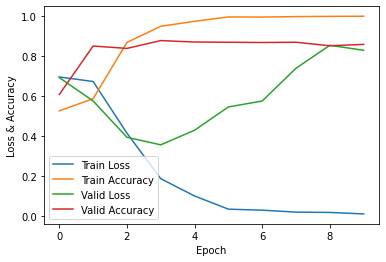

In [ ]:
# 绘制误差曲线
plt.plot([i[0] for i in records], label = 'Train Loss')
plt.plot([i[1] for i in records], label = 'Train Accuracy')
plt.plot([i[2] for i in records], label = 'Valid Loss')
plt.plot([i[3] for i in records], label = 'Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss & Accuracy')
plt.legend()
plt.show()